In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from tqdm.notebook import tqdm
import math
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

In [138]:
df = pd.read_csv('train.csv', low_memory=False)

In [139]:
df["amenities_len"] = 0
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    id_ = row["id"]
    l = len(row["amenities"][1:-1].split(","))
    df.loc[df["id"] == id_, "amenities_len"] = l

  0%|          | 0/74111 [00:00<?, ?it/s]

In [140]:
useless_data = ['description', 'first_review', 'host_since', 'last_review', 'name', 'thumbnail_url', 'zipcode', 'neighbourhood', 'amenities']
df = df.drop(useless_data, axis=1)

In [141]:
df.drop_duplicates(inplace=True)

In [142]:
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '')
df['host_response_rate'] = df['host_response_rate'].astype(float)

In [143]:
df = df.dropna(subset=['host_has_profile_pic', 'host_identity_verified'])

In [144]:
df['host_response_rate'].fillna(df['host_response_rate'].mean(),inplace=True)
df['bathrooms'].fillna(df['bathrooms'].mean(),inplace=True)
df['review_scores_rating'].fillna(df['review_scores_rating'].mean(),inplace=True)
df['bedrooms'].fillna(df['bedrooms'].mean(),inplace=True)
df['beds'].fillna(df['beds'].mean(),inplace=True)

In [145]:
df.reset_index(drop=True, inplace=True)

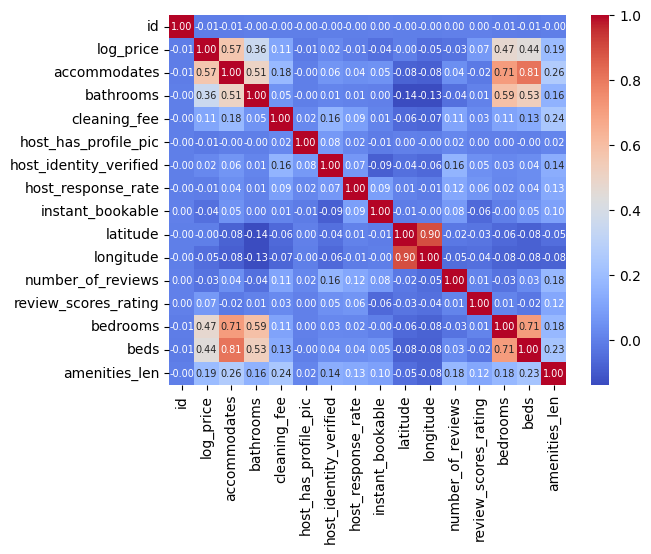

In [146]:
categorical_data = ['city', 'bed_type', 'property_type', 'room_type', 'cancellation_policy']
df_new = df.drop(categorical_data, axis=1)
le = LabelEncoder()
df_new['host_has_profile_pic'] = le.fit_transform(df_new['host_has_profile_pic'])
df_new['host_identity_verified'] = le.fit_transform(df_new['host_identity_verified'])
df_new['instant_bookable'] = le.fit_transform(df_new['instant_bookable'])
df_new['cleaning_fee'] = le.fit_transform(df_new['cleaning_fee'])
sns.heatmap(df_new.corr(),annot=True, fmt='.2f', cmap='coolwarm',annot_kws={'size': 7})
  
# displaying heatmap 
plt.show() 

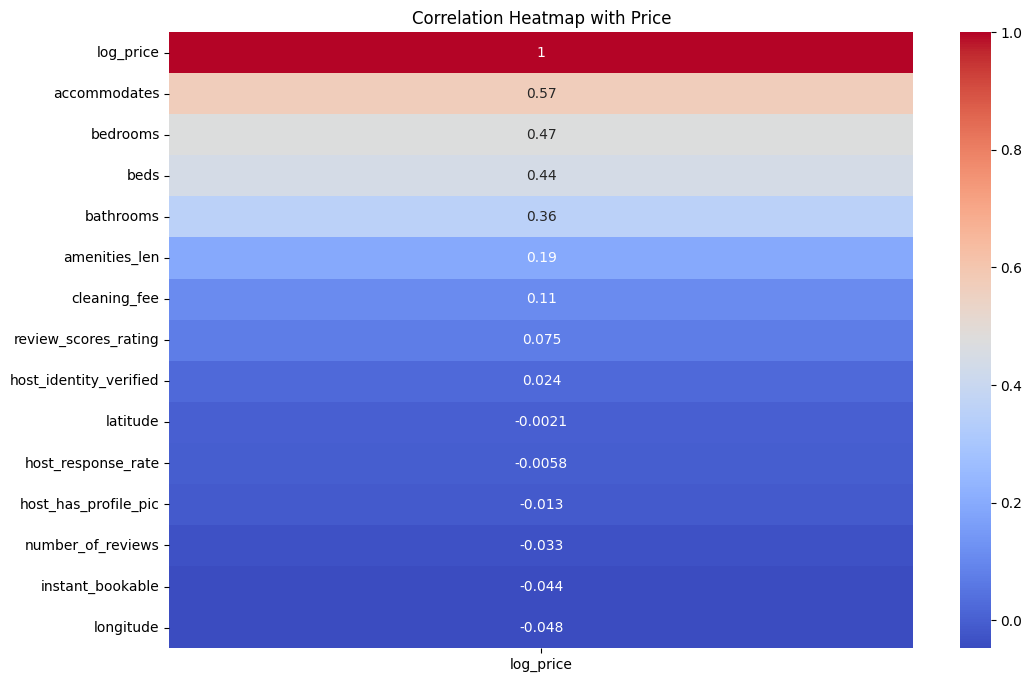

In [147]:
useful_cols = df_new.columns[1:]
corr_matrix = df_new[useful_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['log_price']].sort_values(by='log_price', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Price')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_28560\1714169258.py:16: UserWarning: Attempting to set identical bottom == top == 5 results in singular transformations; automatically expanding.
  plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])


<BarContainer object of 2 artists>

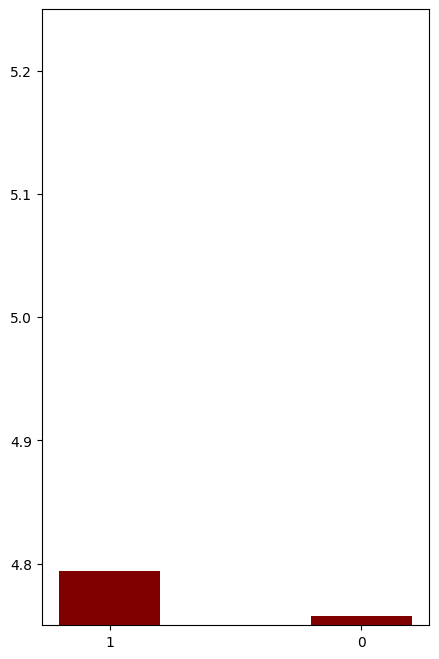

In [148]:
t = 0
f = 0
for i in df_new['host_identity_verified']:
    if(i == 1): t += 1
    else: f += 1
val_1 = np.mean(df_new.loc[df_new["host_identity_verified"] == 1]["log_price"].values, axis=0)
val_0 = np.mean(df_new.loc[df_new["host_identity_verified"] == 0]["log_price"].values, axis=0)

data = {"1": val_1, "0": val_0}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (5, 8))
low = min(values)
high = max(values)
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
plt.bar(courses, values, color ='maroon',
        width = 0.4)

<BarContainer object of 16 artists>

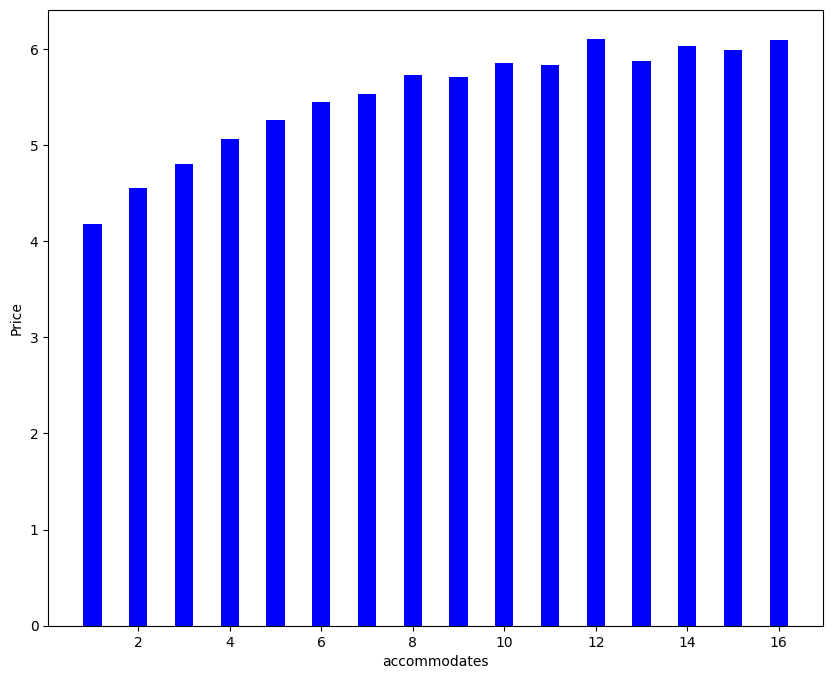

In [149]:
keys = list(range(1,17))
vals = [np.mean(df_new.loc[df_new["accommodates"] == i]["log_price"].values, axis=0) for i in keys]


fig = plt.figure(figsize = (10, 8))
plt.xlabel("accommodates")
plt.ylabel("Price")
plt.bar(keys, vals, color ='blue',
        width = 0.4)

<BarContainer object of 3 artists>

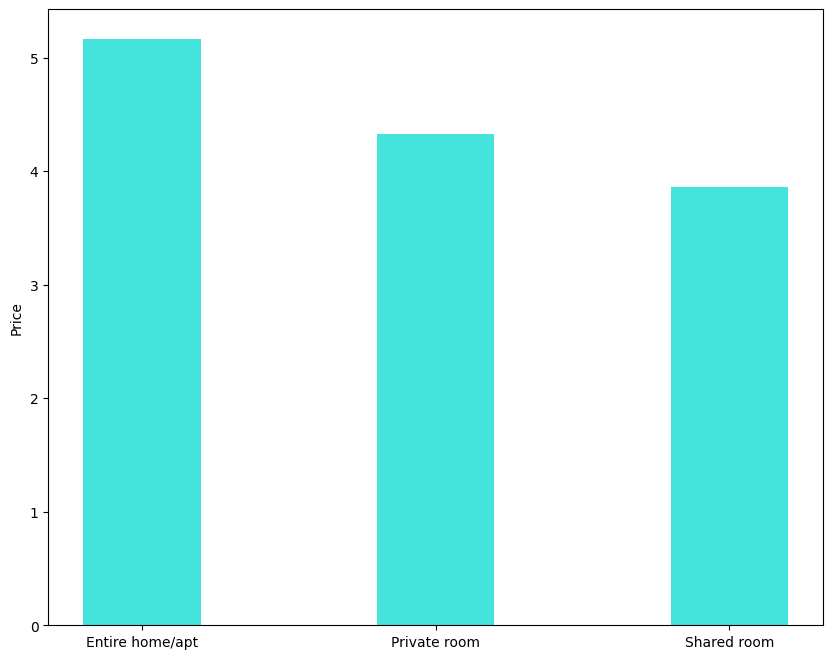

In [150]:
keys = np.unique(df["room_type"].values)

vals = [np.mean(df_new.loc[df["room_type"] == i]["log_price"].values, axis=0) for i in keys]


fig = plt.figure(figsize = (10, 8))
plt.ylabel("Price")
plt.bar(keys, vals, color ='#44e3db',
        width = 0.4)

<BarContainer object of 72 artists>

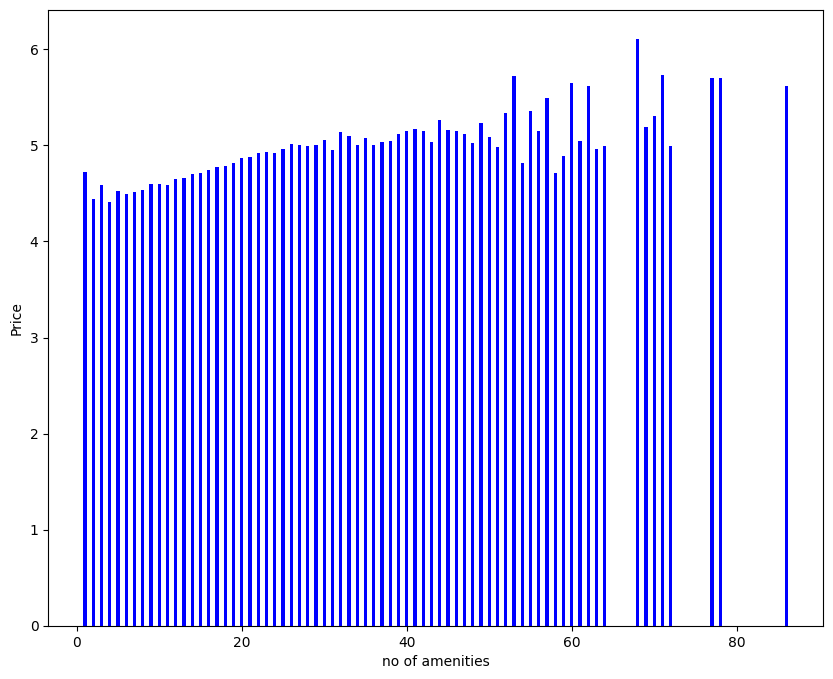

In [151]:
keys = np.unique(df["amenities_len"].values)

vals = [np.mean(df.loc[df["amenities_len"] == i]["log_price"].values, axis=0) for i in keys]


fig = plt.figure(figsize = (10, 8))
plt.xlabel("no of amenities")
plt.ylabel("Price")
plt.bar(keys, vals, color ='blue',
        width = 0.4)

<AxesSubplot:xlabel='log_price'>

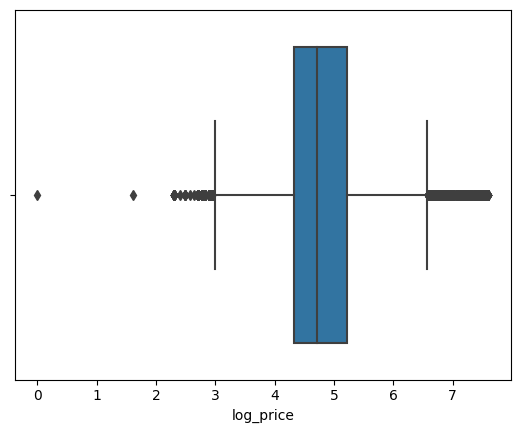

In [152]:
sns.boxplot(x='log_price',  data=df)

In [153]:
df.drop(df[df['log_price'] <3].index, inplace=True)
df.drop(df[df['log_price'] >6.5].index, inplace=True)

In [154]:
df.shape

(72099, 21)

In [155]:
df.reset_index(drop=True, inplace=True)

In [156]:
df1 = df
df2 = df

In [157]:
# Converted binary (true, false) columns to labels
le = LabelEncoder()
df1['host_has_profile_pic'] = le.fit_transform(df1['host_has_profile_pic'])
df1['host_identity_verified'] = le.fit_transform(df1['host_identity_verified'])
df1['instant_bookable'] = le.fit_transform(df1['instant_bookable'])
df1['cleaning_fee'] = le.fit_transform(df1['cleaning_fee'])

In [158]:
# Converted non-binary (categorical) columns to one hot vectors
categorical_data = ['city', 'bed_type', 'property_type', 'room_type', 'cancellation_policy']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
X_encoded = encoder.fit_transform(df1[categorical_data])
encoded_columns = encoder.get_feature_names_out(categorical_data)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_columns)
df_final = pd.concat([df1, X_encoded_df], axis=1)
df1 = df_final

In [159]:
df1.shape

(72099, 70)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


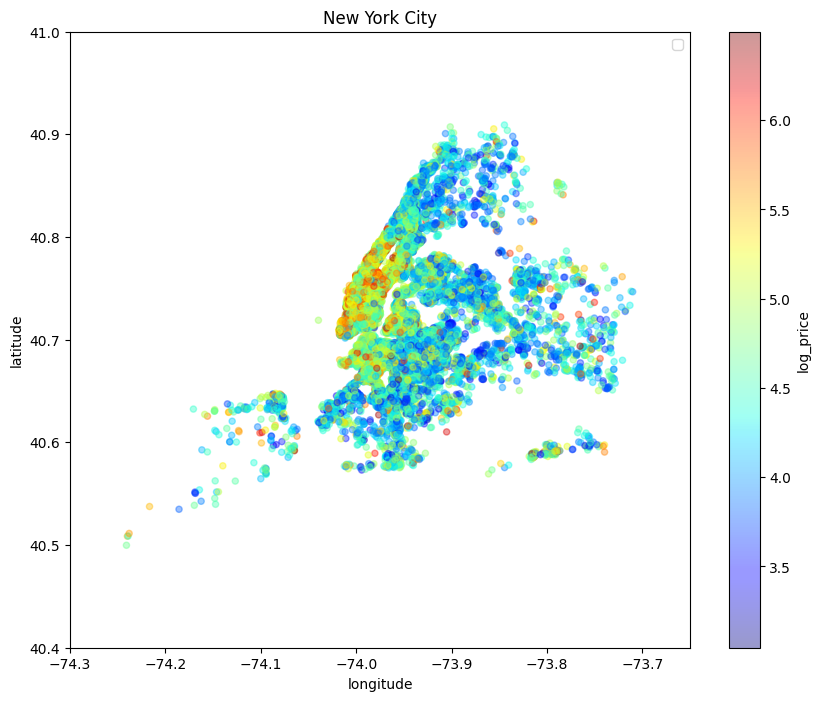

In [160]:
#New York City Plot

less_than_price=df[df.log_price>0]

v1=less_than_price.plot(kind='scatter', x='longitude', y='latitude',c='log_price',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, figsize=(10,8))

v1.set(xlim=(-74.3,-73.65), ylim=(40.4,41))
v1.set_title("New York City")

v1.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


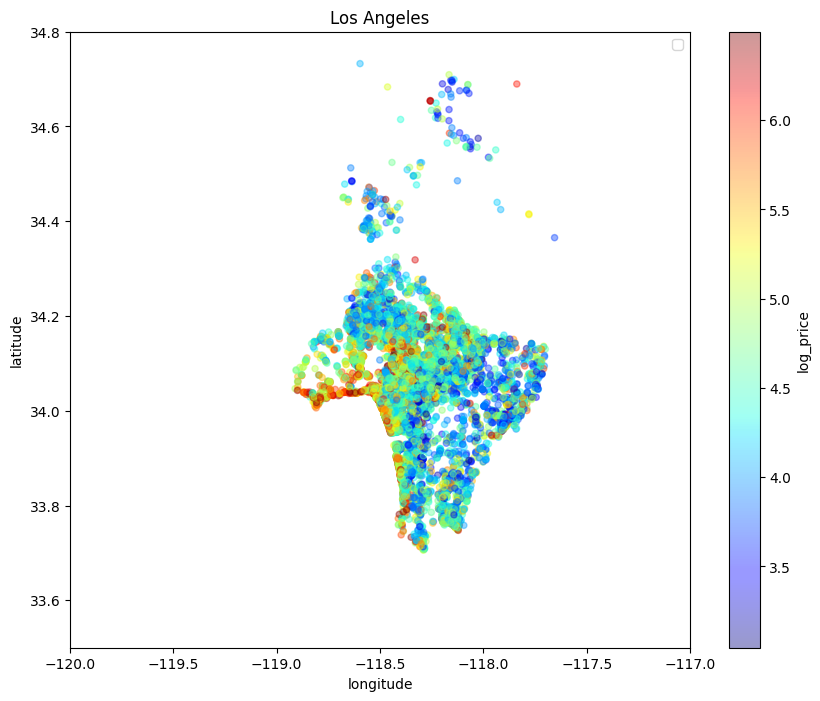

In [161]:
#LA Plot

less_than_price=df[df.log_price>0]

v2=less_than_price.plot(kind='scatter', x='longitude', y='latitude',c='log_price',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, figsize=(10,8))

v2.set(xlim=(-120,-117), ylim=(33.5,34.8))
v2.set_title("Los Angeles")

v2.legend()

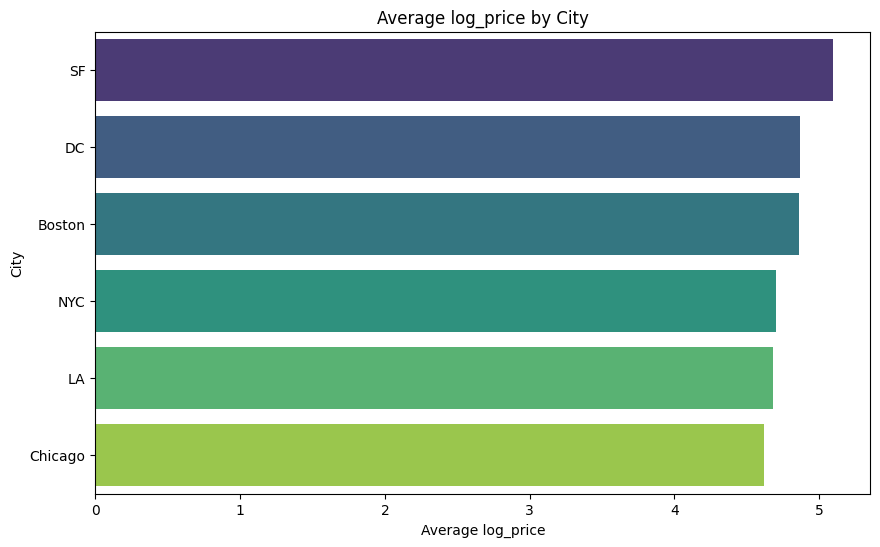

In [162]:
avg_log_price_by_city = df.groupby('city')['log_price'].mean().reset_index()

avg_log_price_by_city = avg_log_price_by_city.sort_values(by='log_price', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_log_price_by_city, x='log_price', y='city', palette='viridis')
plt.title('Average log_price by City')
plt.xlabel('Average log_price')
plt.ylabel('City')
plt.show()

In [163]:
df1 = df1.drop(categorical_data, axis=1)

In [164]:
df1.shape

(72099, 65)

In [165]:
y = df1['log_price']
X = df1.drop('log_price', axis = 1)

In [135]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)
from sklearn.cluster import KMeans
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=6)
X_train_clusters = kmeans.fit_predict(X_train_scaled)
X_test_clusters = kmeans.predict(X_test_scaled)

# One-hot encode cluster memberships
X_train_clusters = pd.get_dummies(X_train_clusters, prefix='cluster')
X_test_clusters = pd.get_dummies(X_test_clusters, prefix='cluster')

# Convert the cluster arrays to DataFrames
X_train_clusters = pd.DataFrame(X_train_clusters, columns=X_train_clusters.columns.map(str))
X_test_clusters = pd.DataFrame(X_test_clusters, columns=X_test_clusters.columns.map(str))

# Combine the cluster membership features with the original features
X_train_with_clusters = pd.concat([pd.DataFrame(X_train_scaled), X_train_clusters], axis=1)
X_test_with_clusters = pd.concat([pd.DataFrame(X_test_scaled), X_test_clusters], axis=1)

X_train_with_clusters.columns = X_train_with_clusters.columns.astype(str)
X_test_with_clusters.columns = X_test_with_clusters.columns.astype(str)

X_train = X_train_with_clusters
X_test = X_test_with_clusters

c:\python 310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [166]:
regressor = LinearRegression()

regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

a1 = mse(y_train, y_train_pred)
b1 = mse(y_train, y_train_pred, squared = False)
c1 = r2(y_train, y_train_pred)
e1 = mae(y_train, y_train_pred)

a2 = mse(y_test, y_test_pred)
b2 = mse(y_test, y_test_pred, squared = False)
c2 = r2(y_test, y_test_pred)
e2 = mae(y_test, y_test_pred)

print(f"Training Data Analysis:\n\nMean Square Error : {a1:.2f}\nRoot Mean Square Error : {b1:.2f}\nR2 Score : {c1:.2f}\nMean Absolute Error : {e1:.2f}\n")
print(f"Test Data Analysis:\n\nMean Square Error : {a2:.2f}\nRoot Mean Square Error : {b2:.2f}\nR2 Score : {c2:.2f}\nMean Absolute Error : {e2:.2f}")

Training Data Analysis:

Mean Square Error : 0.18
Root Mean Square Error : 0.42
R2 Score : 0.57
Mean Absolute Error : 0.33

Test Data Analysis:

Mean Square Error : 0.18
Root Mean Square Error : 0.43
R2 Score : 0.56
Mean Absolute Error : 0.33


In [167]:
# Applying Scaling
categorical_data = ['city', 'bed_type', 'property_type', 'room_type', 'cancellation_policy', "host_has_profile_pic", "host_identity_verified", "instant_bookable", "cleaning_fee"]
df_non_cat = df2.drop(categorical_data, axis=1)
df_non_cat_cols = df_non_cat.columns
sc = StandardScaler()
df_non_cat = sc.fit_transform(df_non_cat)
df_non_cat_Df = pd.DataFrame(df_non_cat, columns=df_non_cat_cols)

In [168]:
df2.reset_index(drop=True, inplace=True)

In [169]:
# Concatinating scaled data and categorical data
df2 = df2.drop(df_non_cat_cols, axis=1)
df2 = pd.concat([df2, df_non_cat_Df], axis=1)

In [170]:
le = LabelEncoder()
df2['host_has_profile_pic'] = le.fit_transform(df2['host_has_profile_pic'])
df2['host_identity_verified'] = le.fit_transform(df2['host_identity_verified'])
df2['instant_bookable'] = le.fit_transform(df2['instant_bookable'])
df2['cleaning_fee'] = le.fit_transform(df2['cleaning_fee'])

In [171]:
categorical_data = ['city', 'bed_type', 'property_type', 'room_type', 'cancellation_policy']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
X_encoded = encoder.fit_transform(df2[categorical_data])
encoded_columns = encoder.get_feature_names_out(categorical_data)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_columns)
df_final = pd.concat([df2, X_encoded_df], axis=1)
df2 = df_final

In [172]:
df2 = df2.drop(categorical_data, axis=1)

In [173]:
y2 = df2['log_price']
X2 = df2.drop('log_price', axis = 1)

In [174]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.2,random_state=101)

In [175]:
regressor = LinearRegression()

regressor.fit(X_train2, y_train2)

y_train_pred2 = regressor.predict(X_train2)
y_test_pred2 = regressor.predict(X_test2)

a1 = mse(y_train2, y_train_pred2)
b1 = mse(y_train2, y_train_pred2, squared = False)
c1 = r2(y_train2, y_train_pred2)
e1 = mae(y_train2, y_train_pred2)

a2 = mse(y_test2, y_test_pred2)
b2 = mse(y_test2, y_test_pred2, squared = False)
c2 = r2(y_test2, y_test_pred2)
e2 = mae(y_test2, y_test_pred2)

print(f"Training Data Analysis:\n\nMean Square Error : {a1:.2f}\nRoot Mean Square Error : {b1:.2f}\nR2 Score : {c1:.2f}\nMean Absolute Error : {e1:.2f}\n")
print(f"Test Data Analysis:\n\nMean Square Error : {a2:.2f}\nRoot Mean Square Error : {b2:.2f}\nR2 Score : {c2:.2f}\nMean Absolute Error : {e2:.2f}")

Training Data Analysis:

Mean Square Error : 0.43
Root Mean Square Error : 0.65
R2 Score : 0.57
Mean Absolute Error : 0.51

Test Data Analysis:

Mean Square Error : 0.44
Root Mean Square Error : 0.66
R2 Score : 0.56
Mean Absolute Error : 0.51


In [116]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.2,random_state=101)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train2)
X_test_scaled = scaler.transform(X_test2)
kmeans = KMeans(n_clusters=6)
X_train_clusters = kmeans.fit_predict(X_train_scaled)
X_test_clusters = kmeans.predict(X_test_scaled)

# One-hot encode cluster memberships
X_train_clusters = pd.get_dummies(X_train_clusters, prefix='cluster')
X_test_clusters = pd.get_dummies(X_test_clusters, prefix='cluster')

# Convert the cluster arrays to DataFrames
X_train_clusters = pd.DataFrame(X_train_clusters, columns=X_train_clusters.columns.map(str))
X_test_clusters = pd.DataFrame(X_test_clusters, columns=X_test_clusters.columns.map(str))

# Combine the cluster membership features with the original features
X_train_with_clusters = pd.concat([pd.DataFrame(X_train_scaled), X_train_clusters], axis=1)
X_test_with_clusters = pd.concat([pd.DataFrame(X_test_scaled), X_test_clusters], axis=1)

X_train_with_clusters.columns = X_train_with_clusters.columns.astype(str)
X_test_with_clusters.columns = X_test_with_clusters.columns.astype(str)

X_train2 = X_train_with_clusters
X_test2 = X_test_with_clusters


c:\python 310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [117]:
pca = PCA(n_components = 50)
X_train_pca = pca.fit_transform(X_train2)
X_test_pca = pca.transform(X_test2)

In [106]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

svm_regressor = SVR(kernel='rbf')
svm_regressor.fit(X_train2, y_train2)

# y_train_pred = svm_regressor.predict(X_train2)
y_test_pred = svm_regressor.predict(X_test2)

# Calculate metrics for test data
a2 = mean_squared_error(y_test2, y_test_pred)
b2 = mean_squared_error(y_test2, y_test_pred, squared=False)
c2 = r2_score(y_test2, y_test_pred)
e2 = mean_absolute_error(y_test2, y_test_pred)

print(f"Test Data Analysis:\n\nMean Square Error : {a2:.2f}\nRoot Mean Square Error : {b2:.2f}\nR2 Score : {c2:.2f}\nMean Absolute Error : {e2:.2f}")

Test Data Analysis:

Mean Square Error : 0.42
Root Mean Square Error : 0.65
R2 Score : 0.58
Mean Absolute Error : 0.50


In [46]:
# X_train, X_test, y_train, y_test = train_test_split(X2,y2,test_size=0.2,random_state=101)

In [119]:
regressor = Lasso(alpha=0.007)

regressor.fit(X_train2, y_train2)

y_train_pred = regressor.predict(X_train2)
y_test_pred = regressor.predict(X_test2)

a1 = mse(y_train2, y_train_pred)
b1 = mse(y_train2, y_train_pred, squared = False)
c1 = r2(y_train2, y_train_pred)
e1 = mae(y_train2, y_train_pred)

a2 = mse(y_test2, y_test_pred)
b2 = mse(y_test2, y_test_pred, squared = False)
c2 = r2(y_test2, y_test_pred)
e2 = mae(y_test2, y_test_pred)

print(f"Training Data Analysis:\n\nMean Square Error : {a1:.2f}\nRoot Mean Square Error : {b1:.2f}\nR2 Score : {c1:.2f}\nMean Absolute Error : {e1:.2f}\n")
print(f"Test Data Analysis:\n\nMean Square Error : {a2:.2f}\nRoot Mean Square Error : {b2:.2f}\nR2 Score : {c2:.2f}\nMean Absolute Error : {e2:.2f}")

Training Data Analysis:

Mean Square Error : 0.45
Root Mean Square Error : 0.67
R2 Score : 0.55
Mean Absolute Error : 0.52

Test Data Analysis:

Mean Square Error : 0.46
Root Mean Square Error : 0.67
R2 Score : 0.54
Mean Absolute Error : 0.52


In [120]:
regressor = Ridge(alpha=0.007)

regressor.fit(X_train2, y_train2)

y_train_pred = regressor.predict(X_train2)
y_test_pred = regressor.predict(X_test2)

a1 = mse(y_train2, y_train_pred)
b1 = mse(y_train2, y_train_pred, squared = False)
c1 = r2(y_train2, y_train_pred)
e1 = mae(y_train2, y_train_pred)

a2 = mse(y_test2, y_test_pred)
b2 = mse(y_test2, y_test_pred, squared = False)
c2 = r2(y_test2, y_test_pred)
e2 = mae(y_test2, y_test_pred)

print(f"Training Data Analysis:\n\nMean Square Error : {a1:.2f}\nRoot Mean Square Error : {b1:.2f}\nR2 Score : {c1:.2f}\nMean Absolute Error : {e1:.2f}\n")
print(f"Test Data Analysis:\n\nMean Square Error : {a2:.2f}\nRoot Mean Square Error : {b2:.2f}\nR2 Score : {c2:.2f}\nMean Absolute Error : {e2:.2f}")

Training Data Analysis:

Mean Square Error : 0.43
Root Mean Square Error : 0.65
R2 Score : 0.57
Mean Absolute Error : 0.51

Test Data Analysis:

Mean Square Error : 0.44
Root Mean Square Error : 0.66
R2 Score : 0.56
Mean Absolute Error : 0.51


After Midsem

In [111]:
y = df1['log_price']
X = df1.drop('log_price', axis=1)

In [112]:
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [122]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)
# Apply PCA
# pca = PCA(n_components=25)  # You can adjust the number of components as needed
# X_train_pca = pca.fit_transform(X_train_normalized)
# X_test_pca = pca.transform(X_test_normalized)
# print(X_train2.shape)
# Create an MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(512, 256), max_iter=100, activation='logistic', batch_size=200)

# Train the model with PCA-transformed data
model.fit(X_train2, y_train2)

# Make predictions using PCA-transformed test data
pred = model.predict(X_test2)

a2 = mse(y_test2, pred)
b2 = mse(y_test2, pred, squared = False)
c2 = r2(y_test2, pred)
e2 = mae(y_test2, pred)

print(f"Test Data Analysis:\n\nMean Square Error : {a2:.2f}\nRoot Mean Square Error : {b2:.2f}\nR2 Score : {c2:.2f}\nMean Absolute Error : {e2:.2f}")


c:\python 310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Data Analysis:

Mean Square Error : 0.42
Root Mean Square Error : 0.65
R2 Score : 0.57
Mean Absolute Error : 0.50


In [130]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Assuming you have your training and testing data ready
# X_train, X_test are your features, y_train, y_test are your target prices

# Normalize the data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train2)
X_test_normalized = scaler.transform(X_test2)

# Create an MLPRegressor
mlp = MLPRegressor(max_iter=100)

# Define the parameter grid to search
param_grid = {
    'hidden_layer_sizes': [(256,128), (128, 128)],
    'activation': ['relu', 'tanh','logistic'],
    'batch_size': [200, 500],
}

# Create GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_normalized, y_train2)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions using the best model
predictions = best_model.predict(X_test_normalized)

mse = mean_squared_error(y_test2, predictions)
mae = mean_absolute_error(y_test2, predictions)
rmse = mean_squared_error(y_test2, predictions, squared=False)
r2 = r2_score(y_test2, predictions)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared (R²) Score: {r2:.2f}')


c:\python 310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error: 0.42
Mean Absolute Error: 0.50
Root Mean Squared Error: 0.65
R-squared (R²) Score: 0.57


In [131]:
grid_search.best_params_

{'activation': 'logistic', 'batch_size': 200, 'hidden_layer_sizes': (256, 128)}

In [125]:
# DECISION TREE REGRESSOR

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

decision_tree = DecisionTreeRegressor(random_state=42)

decision_tree.fit(X_train2, y_train2)

predictions = decision_tree.predict(X_test2)

mse = mean_squared_error(y_test2, predictions)
mae = mean_absolute_error(y_test2, predictions)
rmse = mean_squared_error(y_test2, predictions, squared=False)
r2 = r2_score(y_test2, predictions)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared (R²) Score: {r2:.2f}')

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features':['sqrt',None]
}

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train2, y_train2)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Use the best model found by GridSearchCV
best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test2)

mse = mean_squared_error(y_test2, predictions)
mae = mean_absolute_error(y_test2, predictions)
rmse = mean_squared_error(y_test2, predictions, squared=False)
r2 = r2_score(y_test2, predictions)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared (R²) Score: {r2:.2f}')

Mean Squared Error: 0.60
Mean Absolute Error: 0.58
Root Mean Squared Error: 0.78
R-squared (R²) Score: 0.39
Best Hyperparameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mean Squared Error: 0.37
Mean Absolute Error: 0.46
Root Mean Squared Error: 0.61
R-squared (R²) Score: 0.63


In [126]:
# RANDOM FOREST REGRESSOR

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV


# Define the Random Forest model
random_forest = RandomForestRegressor(n_estimators=200,random_state=42)

random_forest.fit(X_train2,y_train2)

predictions=random_forest.predict(X_test2)

# Evaluate the performance using various metrics
mse = mean_squared_error(y_test2, predictions)
mae = mean_absolute_error(y_test2, predictions)
rmse = mean_squared_error(y_test2, predictions, squared=False)
r2 = r2_score(y_test2, predictions)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared (R²) Score: {r2:.2f}')

Mean Squared Error: 0.31
Mean Absolute Error: 0.41
Root Mean Squared Error: 0.56
R-squared (R²) Score: 0.69


In [128]:
# Define the parameter grid to search through
param_grid = {
    'learning_rate': [0.1, 0.01,0.3],
    'max_depth': [3, 4, 5,6 ,10],
    'subsample': [0.8, 0.9, 1.0]
}

# Create an XGBRegressor model
xgb_regressor = XGBRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the grid search on your training data
grid_search.fit(X_train2, y_train2)

# Print the best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions using the best model
predictions = best_model.predict(X_test2)

# Evaluate the performance using various metrics
mse = mean_squared_error(y_test2, predictions)
mae = mean_absolute_error(y_test2, predictions)
rmse = mean_squared_error(y_test2, predictions, squared=False)
r2 = r2_score(y_test2, predictions)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared (R²) Score: {r2:.2f}')

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 10, 'subsample': 0.9}
Mean Squared Error: 0.30
Mean Absolute Error: 0.41
Root Mean Squared Error: 0.55
R-squared (R²) Score: 0.70
